# Проект: отток банковских клиентов
Из банка стали уходить клиенты. Маркетологи посчитали, что сохранять имеющихся клиентов выгоднее, чем привлекать новых. В нашем распоряжении данные о клиентах банка, текущих и расторгнувших договор.

---

## Цель проекта: построить модель-классификатор, которая определит вероятность того, что отдельно взятый клиент расторгнет договор с банком.
Мы попытаемся построить **модель-классификатор**, которая максимально точно выявит клиентов банка, которые уйдут в ближайшее время, основываясь на имеющейся информации об этих клиентах.

В качестве метрики качества модели мы будем использовать главным образом *F1-меру*, которая представляет собой баланс метрик *precision* и *recall*, а также будем оценивать *AUROC* моделей. Минимальным значением F1 для нас по условию является *0.59*.

---

## План проекта <a id="toc"></a>

1. [Откроем и изучим файл с данными](#first-look)
2. [Подготовим данные к построению моделей](#prep)
2. [Исследуем баланс классов, обучим модели без учёта дисбаланса](#unbalanced)
3. [Улучшим качество моделей, учитывая дисбаланс классов](#balanced)
4. [Проведём финальное тестирование с лучшей моделью](#test)
5. [Сделаем выводы](#conclusion)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

---

## 1. Откроем и изучим файл с данными <a id="first-look"></a>

In [2]:
file_path = '../../../Churn/datasets/Churn.csv'
data = pd.read_csv(file_path)

In [3]:
data.shape

(10000, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


- Данные имеют подходящие типы во всех столбцах. Строковые данные мы позже закодируем в числовой вид.
- Есть **пропуски** в столбце с данными о наличии недвижимости. Первая мысль: у этих клиентов **может не быть недвижимости** в собственности. Исследуем это явление позже.
- Столбцы имеют заглавные символы в названиях и названы не до конца удобно. **Переназовём** их сразу же.

In [5]:
# В нижний регистр
data.columns = data.columns.str.lower()
data.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [6]:
data.rename({'customerid': 'id',
             'geography': 'geo',
             'isactivemember': 'isactive',
             'numofproducts': 'products',
             'hascrcard': 'hascard',
             'estimatedsalary': 'salary',
             'exited': 'churn'}, axis=1, inplace=True)

In [7]:
data.head()

,rownumber,id,surname,creditscore,geo,gender,age,tenure,balance,products,hascard,isactive,salary,churn
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Столбец `rownumber` выглядит абсолютно бесполезным. Удалим его.

In [8]:
data.drop('rownumber', axis=1, inplace=True)

Проверим данные на наличие дубликатов **и** вычтем из длины датафрейма количество уникальных значений для каждого столбца: так мы найдём **неуникальные** значения.

In [9]:
display(data.duplicated().sum())
data.shape[0] - data.nunique()

0

id                0
surname        7068
creditscore    9540
geo            9997
gender         9998
age            9930
tenure         9989
balance        3618
products       9996
hascard        9998
isactive       9998
salary            1
churn          9998
dtype: int64

- Грубые дубликаты строк отсутствуют.
- Нас очень интересуют `id`: все они уникальны. Сделаем столбец `id` индексом датафрейма. Тем более, что `id` не годится в качестве признака.
- У нас встречается очень большое число **неуникальных фамилий**: этот признак вряд ли может помочь модели в увеличении точности прогнозов. Избавимся от него.
- Для стран, категориальных и количественных признаков **дублирование допустимо**. Они не претендуют на уникальность.

In [10]:
# id берём за индекс
data.set_index('id', drop=True, inplace=True)

# Сохраним фамилии в словарик по id и удалим из таблицы
surnames = data.surname
data.drop(['surname'], inplace=True, axis=1)

In [11]:
data.sample(3)

,creditscore,geo,gender,age,tenure,balance,products,hascard,isactive,salary,churn
id,,,,,,,,,,,
15763579,702,Germany,Female,36,2.0,105264.88,2,1,1,52909.87,0
15754267,697,Germany,Male,31,3.0,108805.42,2,0,1,123825.83,0
15683503,601,France,Female,43,8.0,0.00,3,0,1,110916.15,1


У нас в ячейках есть строковые значения с верхним регистром. Преобразуем их в нижний.

In [12]:
for col in ['geo', 'gender']:
    data.loc[:, col] = data.loc[:, col].apply(lambda x: x.lower())

In [13]:
data.sample(3)

,creditscore,geo,gender,age,tenure,balance,products,hascard,isactive,salary,churn
id,,,,,,,,,,,
15570051,775,germany,female,38,6.0,179886.41,2,0,0,153122.58,0
15728474,558,germany,male,32,4.0,108235.91,1,1,1,143783.28,0
15680243,792,france,male,19,7.0,143390.51,1,1,0,33282.84,0


Совсем другое дело.

In [14]:
from toads.eda import describe

In [15]:
describe(data)

,count,mean,std,min,25%,50%,75%,max,na_part
creditscore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,0.0000
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,0.0000
tenure,9091.0,4.997690,2.894723,0.00,2.00,5.000,7.0000,10.00,0.0909
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,0.0000
products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,0.0000
hascard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00,0.0000
isactive,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00,0.0000
salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,0.0000
churn,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00,0.0000
geo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000


- Количественные признаки имеют разный масштаб: посмотрим глазами на их распределения. Для этого возьмём функции-помощники из предыдущих проектов.

Нарисуем гистограммы для каждого количественного столбца.

In [16]:
from toads.image import Image

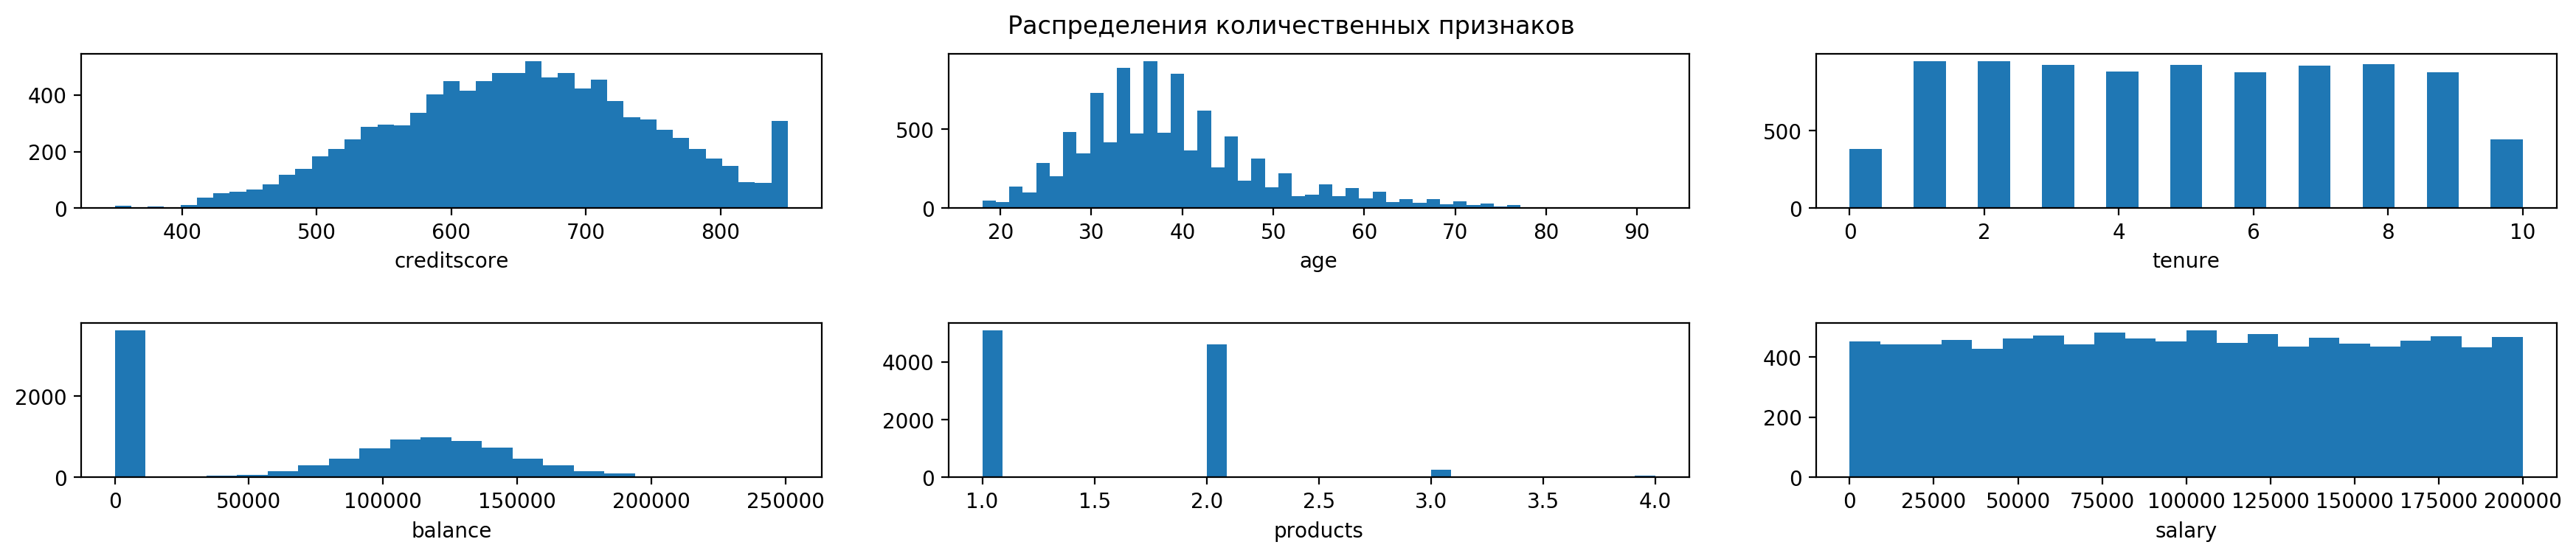

In [17]:
num_cols = ['creditscore', 'age', 'tenure', 'balance', 'products', 'salary']
with Image(18, 4, st='Распределения количественных признаков', tight=True):
    for i, col in enumerate(num_cols):
        Image.subplot(231+i, sx=False)
        sns.distplot(data[col], kde=False, hist_kws={'alpha':1})

- Распределения зарплат и наличия недвижимости выглядят практически ровными. Возможно, что наша выборка из 10000 человек стратифицирована по зарплате.
- Количество банковских продуктов сложно оценить по распределению.

### Вывод из первичного изучения данных
- Данные имеют **удобоваримый вид**. Есть пропуски, с которыми мы поработаем на следующем этапе.
- Мы обнаружили, что некоторые данные **не имеют смысла** для дальнейшего обучения модели: например, это *фамилия* и *id* клиента. Мы исключили их из числа признаков.

[к оглавлению](#toc)

---

## 2. Подготовка данных к построению модели <a id="prep"></a>

В этом блоке мы:
- [Решим проблему пропусков в данных о недвижимости](#tenure)
- [Закодируем категориальные признаки](#encoding)
- [Попытаемся извлечь из имеющихся данных дополнительные столбцы](#extraction)
- [Масштабируем количественные признаки](#scaling)
- [**Разделим данные** на фичи и целевой признак, на учебную, валидационную и тестовую выборки.](#split)

### Пропуски в данных о недвижимости <a id="tenure"></a>

Мы предположили, что данные с пропусками в недвижимости могут подразумевать отсутствие таковой. Заполнять будем нулями, но для начала попытаемся понять причину такого явления среди данных. Вдруг это возраст или какой-то другой фактор?

In [18]:
describe(data.query('tenure.isna()'))

,count,mean,std,min,25%,50%,75%,max,na_part
creditscore,909.0,648.451045,99.079381,359.00,580.00,647.00,718.00,850.00,0.0
age,909.0,38.647965,9.785438,18.00,32.00,37.00,43.00,92.00,0.0
tenure,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
balance,909.0,76117.341474,63105.690715,0.00,0.00,96674.55,128554.98,206663.75,0.0
products,909.0,1.530253,0.588452,1.00,1.00,1.00,2.00,4.00,0.0
hascard,909.0,0.710671,0.453701,0.00,0.00,1.00,1.00,1.00,0.0
isactive,909.0,0.510451,0.500166,0.00,0.00,1.00,1.00,1.00,0.0
salary,909.0,99180.389373,56378.063765,106.67,49872.33,99444.02,145759.70,199390.45,0.0
churn,909.0,0.201320,0.401207,0.00,0.00,0.00,0.00,1.00,0.0
geo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


А что, если дело в стране?

In [19]:
data.query('tenure.isna()').geo.value_counts()

france     464
spain      229
germany    216
Name: geo, dtype: int64

А какие вообще есть страны?

In [20]:
data.geo.unique()

array(['france', 'spain', 'germany'], dtype=object)

Ничего необычного и всего три страны. Похоже, что данные не зависят ни от клиента, ни от его страны.  Заполним нулями.

In [21]:
data.tenure.fillna(0, inplace=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   creditscore  10000 non-null  int64  
 1   geo          10000 non-null  object 
 2   gender       10000 non-null  object 
 3   age          10000 non-null  int64  
 4   tenure       10000 non-null  float64
 5   balance      10000 non-null  float64
 6   products     10000 non-null  int64  
 7   hascard      10000 non-null  int64  
 8   isactive     10000 non-null  int64  
 9   salary       10000 non-null  float64
 10  churn        10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


Отлично, теперь у нас нет пропусков.

---

### Кодирование категориальных признаков <a id="encoding"></a>

Рассмотрим признаки, которые могут потребовать кодирования.

In [23]:
data.head()

,creditscore,geo,gender,age,tenure,balance,products,hascard,isactive,salary,churn
id,,,,,,,,,,,
15634602,619,france,female,42,2.0,0.00,1,1,1,101348.88,1
15647311,608,spain,female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,502,france,female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,699,france,female,39,1.0,0.00,2,0,0,93826.63,0
15737888,850,spain,female,43,2.0,125510.82,1,1,1,79084.10,0


**Страна и пол** - эту парочку нам точно нужно перевести в числовой вид. Остальные данные уже имеют подходящее представление.

Мы собираемся использовать OHE для кодирования категориальных данных. На всякий случай оценим количество значений в этих столбцах. Иначе мы можем раздуть размер датафрейма, если уникальных значений окажется слишком много.

In [24]:
cat = ['geo', 'gender']

data.nunique().loc[cat]

geo       3
gender    2
dtype: int64

Три разных страны, два пола. OHE нам прекрасно подходит.

In [25]:
# Закодируем столбцы по-новому, а старые удалим. Также удалим первые сгенерированные столбцы OHE. Они не имеют смысла.
data = data.drop(cat, axis=1).join(pd.get_dummies(data[cat], drop_first=True))

In [26]:
data.sample(2)

,creditscore,age,tenure,balance,products,hascard,isactive,salary,churn,geo_germany,geo_spain,gender_male
id,,,,,,,,,,,,
15738980,506,43,2.0,0.0,2,1,0,105568.60,0,0,0,1
15585734,803,41,9.0,137742.9,2,1,1,166957.82,0,1,0,1


Отлично. Теперь наши категориальные данные должны легче восприниматься моделями.

---

### Извлечение дополнительных данных <a id="extraction"></a>
Когда мы смотрели на данные о балансе на счетах клиентов, мы увидели очень много нулевых балансов. Это может быть как-то связано с активностью клиентов. Попробуем создать дополнительный столбец, который будет маркером нулевого баланса.

In [27]:
data.loc[:, 'zero_balance'] = (data.balance == 0).astype('int')
data.zero_balance.head()

id
15634602    1
15647311    0
15619304    0
15701354    1
15737888    0
Name: zero_balance, dtype: int64

---

### Разделение данных на выборки <a id="split"></a>

In [28]:
from sklearn.model_selection import train_test_split
from toads.ml import xy_split
from toads.eda import print_shapes

In [29]:
def train_val_test(df, r_state=None, strat=None):
    """Делит датасет на три выборки в отношении 3:1:1"""
    train_val, test = train_test_split(df, test_size=0.2, random_state=r_state, stratify=df[strat])
    train, val = train_test_split(train_val, test_size=0.25, random_state=r_state, stratify=train_val[strat])
    return train, val, test

In [30]:
# Делим данные на три выборки и пополам на x и y.
x_train, y_train, x_val, y_val, x_test, y_test = xy_split(train_val_test(data, r_state=0, strat='churn'), 'churn', as_list=True)

In [31]:
print_shapes(x_train, x_val, x_test, y_train, y_val, y_test)

(6000, 12)
(2000, 12)
(2000, 12)
(6000,)
(2000,)
(2000,)


Разделение данных получилось верным и стратифицированным.

---

### Масштабирование количественных признаков <a id="scaling"></a>

Мы приведём количественные признаки в стандартизированный вид, чтобы модель воспринимала их важность как равную.

In [32]:
numeric = ['age', 'tenure', 'products', 'creditscore', 'balance', 'salary']

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
# Обучим scaler на обучающей выборке
ss = StandardScaler()

In [35]:
# Преобразуем данные в выборках
x_train.loc[:, numeric] = ss.fit_transform(x_train[numeric])
x_val.loc[:, numeric] = ss.transform(x_val[numeric])
x_test.loc[:, numeric] = ss.transform(x_test[numeric])

In [36]:
for x in [x_train, x_val, x_test]:
    display(x.sample())

,creditscore,age,tenure,balance,products,hascard,isactive,salary,geo_germany,geo_spain,gender_male,zero_balance
id,,,,,,,,,,,,
15592578,-0.385469,0.194886,0.799627,1.125487,0.827489,0,0,0.645051,0,1,0,0


,creditscore,age,tenure,balance,products,hascard,isactive,salary,geo_germany,geo_spain,gender_male,zero_balance
id,,,,,,,,,,,,
15580988,1.969697,-0.949541,1.121884,-1.233068,0.827489,1,1,0.397137,0,0,1,1


,creditscore,age,tenure,balance,products,hascard,isactive,salary,geo_germany,geo_spain,gender_male,zero_balance
id,,,,,,,,,,,,
15809178,-0.850304,0.290255,1.444141,1.111097,-0.89525,1,0,-1.172183,1,0,0,0


У нас получилось стандартизировать признаки. Теперь они выглядят не очень интуитивно для нас, но более понятно для логистической регрессии. Теперь модель сможет оценивать признаки по единой шкале, основанной на стандартном отклонении.

### Вывод из подготовки данных

- Мы заполнили пропуски в столбце с данными о недвижимости, предположив, что отсутствие значения означает отсутствие недвижимости.
- Закодировали категориальные признаки `gender` и `geo` по принципу *One-Hot Encoding*.
- Добавили столбец, обозначающий отсутствие денег на счетах клиентов. Мы предположили, что этот фактор может быть полезен для предсказаний.
- Преобразовали количественные признаки, чтобы они воспринимались моделью не буквально, а в масштабе стандартных отклонений от среднего, одинаковом для всех количественных признаков.
- Разделили данные на обучающую, валидационную и тестовую выборки.

Теперь мы готовы к обучению модели и оценке её качества.

[к оглавлению](#toc)

---

## 3. Исследование баланса классов. Обучение модели без учёта дисбаланса. <a id="unbalanced"></a>

Чтобы наша модель считала отрицательный и положительный классы важными в равной степени, мы должны сначала понять, существует ли разница в количестве объектов этих классов.

In [37]:
y_train.value_counts()

0    4777
1    1223
Name: churn, dtype: int64

Наглядно видим, что объектов положительного класса в тренировочной выборке в 4 раза больше, чем отрицательных. Это значит, что мы можем создать классификатор с нулями, и его *accuracy* будет близка к *80%* без каких-либо усилий. Проверим это.

In [38]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_validate

In [39]:
# Запишем метрики в список для кросс-валидации
scorers = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

# Будем вызывать датафрейм по короткому имени
df = pd.DataFrame
df(cross_validate(DummyClassifier(strategy='most_frequent'), x_train, y_train, cv=5, scoring=scorers))

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1,test_roc_auc
0,0.002565,0.004639,0.796667,0.0,0.0,0.0,0.5
1,0.002616,0.004145,0.796667,0.0,0.0,0.0,0.5
2,0.001690,0.003707,0.795833,0.0,0.0,0.0,0.5
3,0.001281,0.004309,0.795833,0.0,0.0,0.0,0.5
4,0.001426,0.003677,0.795833,0.0,0.0,0.0,0.5


Даже сломанный классификатор показывает точность 80%. При этом *auroc* и *f1* выглядят гораздо менее убедительно, точнее, совсем никак, потому что битая модель не угадала ни одной единицы. Мы попытаемся обучить более умную модель, но баланс классов пока не будем учитывать, чтобы проверить, будет ли разница от балансировки в дальнейшем.

### Случайный лес
Мы будем подбирать оптимальные параметры при помощи инструмента gridsearch, который автоматически перебирает параметры моделей и производит кросс-валидацию на учебной выборке. Мы не будем скупиться на метрики, но лучшие параметры будем оценивать по *F1-мере*.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [41]:
# Зададим перебираемые параметры. Кое-какие выставим заранее для экономии времени, мы их уже нашли этим же способом.
forest_gs = GridSearchCV(RandomForestClassifier(n_estimators=30, random_state=0),
                         param_grid={'max_depth': range(5, 31, 2),
                                    'min_samples_leaf': range(2, 5),
                                    'min_samples_split': range(2, 5),
                                    'criterion': ['gini', 'entropy']}, cv=4, scoring=scorers, refit='f1')

In [42]:
%%time
forest_gs.fit(x_train, y_train)

CPU times: user 2min 8s, sys: 2.14 s, total: 2min 11s
Wall time: 2min 13s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=None,
                                              oob_score=False, random_state=0,
                                    

Теперь посмотрим, какого наилучшего F1 удалось достичь в процессе поиска оптимальных параметров.

In [43]:
forest_gs.best_score_

0.5908770328565022

In [44]:
df(forest_gs.cv_results_).iloc[forest_gs.best_index_]

mean_fit_time                                                       0.114306
std_fit_time                                                       0.0027341
mean_score_time                                                    0.0195829
std_score_time                                                    0.00112915
param_criterion                                                         gini
param_max_depth                                                           15
param_min_samples_leaf                                                     4
param_min_samples_split                                                    2
params                     {'criterion': 'gini', 'max_depth': 15, 'min_sa...
split0_test_accuracy                                                0.863333
split1_test_accuracy                                                0.867333
split2_test_accuracy                                                0.870667
split3_test_accuracy                                                0.863333

- F1 в среднем уже достигает требуемого значения в *0.59*.
- AUROC в среднем составляет *~0.85*.
- Полнота в среднем составляет *~0.49*, что намекает нам на возможную необходимость снизить пороговое значение вероятности.

**Почему важна именно полнота**: поскольку мы решаем бизнес-задачу с клиентами, которые потенциально могут расторгнуть договор с нашим банком, то для нас самой худшей будет ошибка второго рода - ложноотрицательный ответ (FN), из-за которого мы упустим клиента, которого не подозревали в неверности нашему банку.

In [45]:
forest = forest_gs.best_estimator_

Нарисуем ROC-кривую, чтобы лучше понять, какое пороговое значение вероятности для нас допустимо, чтобы отнести клиента в зону риска.

In [46]:
forest_proba = forest.predict_proba(x_val)[:, 1]
fpr, tpr, thr = roc_curve(y_val, forest_proba)

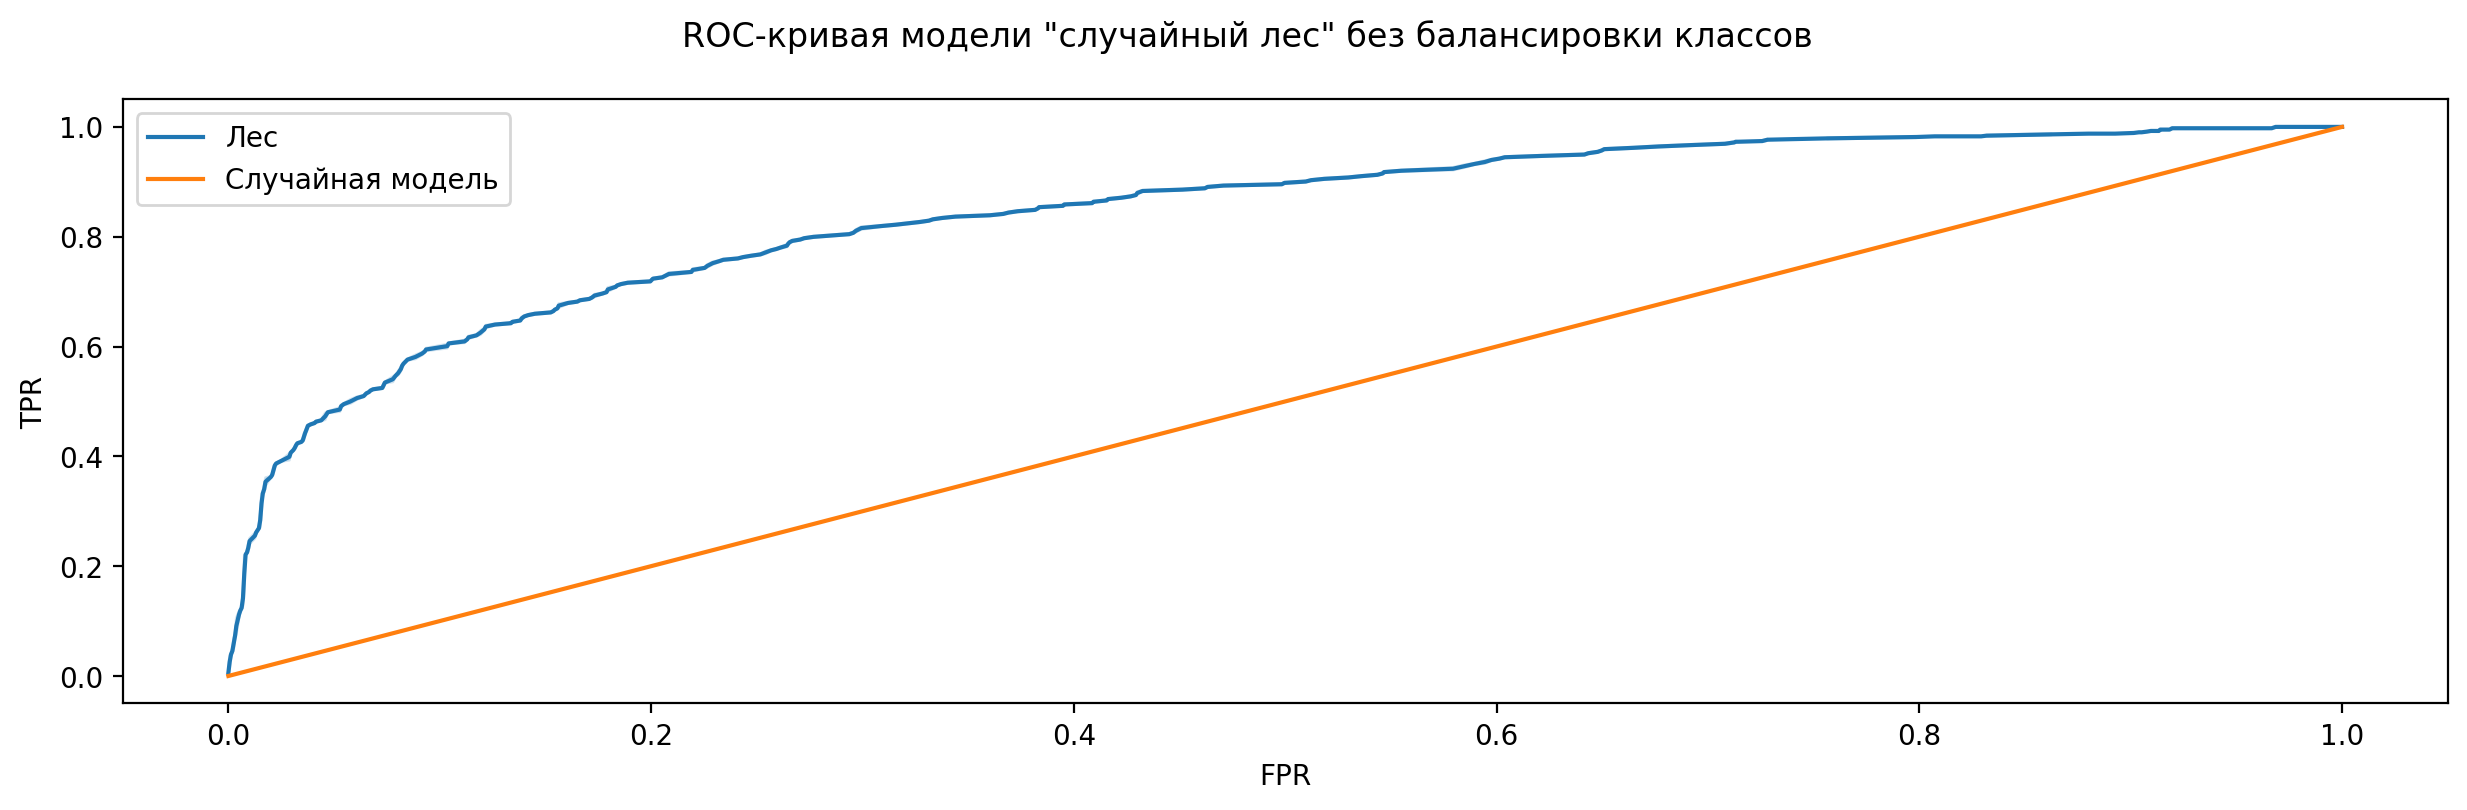

In [47]:
with Image(st='ROC-кривая модели "случайный лес" без балансировки классов'):
    sns.lineplot(fpr, tpr, label='Лес')
    sns.lineplot([0, 1], [0, 1], label='Случайная модель')
    Image.labels('FPR', 'TPR')

Увиденное наталкивает на мысль: если слегка увеличить полноту и снизить точность, то мера F1 должна остаться на месте. Попробуем перебрать пороговые значения, чтобы выбрать оптимальное.

Теперь выделим подходящие для нас значения F1 и найдём порог, при котором получили максимальную полноту.

In [48]:
from toads.ml import proba_thresholds

In [49]:
forest_f1_enough = proba_thresholds(forest, x_val, y_val).query('f1 >=0.59')
forest_best_unbal = forest_f1_enough.loc[forest_f1_enough.recall.idxmax(), :]
forest_best_unbal

threshold    0.265000
accuracy     0.817500
f1           0.593993
recall       0.656020
precision    0.542683
roc_auc      0.757388
Name: 53, dtype: float64

Оптимальным для нашей задачи оказался порог вероятности, равный *0.275*. При этом значении порога мы даём наибольшее количество положительных ответов, не падая ниже *F1 == 0.59*.

### Вывод по случайному лесу
- Мы использовали grid search для подбора оптимальных гиперпараметров случайного леса.
- В лучшем своём проявлении модель по своему значению F1 колеблется на грани допустимого.
- Чтобы улучшить полноту ответов и распознать больше клиентов, мы прибегли к *снижению порога вероятности*. Доля ложноположительных ответов возросла, зато F1 при этом удалось сохранить.

---

### Логистическая регрессия
Одно знаем точно: регрессия будет работать быстрее, чем лес, а какова её точность, мы сейчас измерим.

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
lr_gs = GridSearchCV(LogisticRegression(random_state=0),
                    param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                               'fit_intercept': [True, False],
                               'C': np.arange(1., 0, -0.1)},
                    scoring=scorers, refit='f1')

In [52]:
lr_gs.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]),
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
      

Посмотрим, какой наилучший результат показала логистическая регрессия без балансировки классов.

In [53]:
df(lr_gs.cv_results_).iloc[lr_gs.best_index_]

mean_fit_time                                                    0.0126819
std_fit_time                                                   0.000614019
mean_score_time                                                 0.00467191
std_score_time                                                 4.63287e-05
param_C                                                                0.7
param_fit_intercept                                                  False
param_solver                                                     newton-cg
params                   {'C': 0.7000000000000001, 'fit_intercept': Fal...
split0_test_accuracy                                              0.806667
split1_test_accuracy                                                0.8125
split2_test_accuracy                                                0.8075
split3_test_accuracy                                              0.814167
split4_test_accuracy                                                0.8075
mean_test_accuracy       

Средняя F1 логистической регрессии пугающе низкая. Попробуем перебрать пороги вероятности так же, как делали с лесом.

In [54]:
# Сохраним модель с оптимальными параметрами
lr = lr_gs.best_estimator_

In [55]:
# Сохраним датафрейм с помощью нашей функции
lr_thresholds = proba_thresholds(lr, x_val, y_val)
lr_thresholds.head()

,threshold,accuracy,f1,recall,precision,roc_auc
0,0.000,0.2035,0.338180,1.000000,0.203500,0.500000
1,0.005,0.2035,0.338180,1.000000,0.203500,0.500000
2,0.010,0.2040,0.338321,1.000000,0.203602,0.500314
3,0.015,0.2065,0.339025,1.000000,0.204112,0.501883
4,0.020,0.2120,0.340034,0.997543,0.204947,0.504421


In [56]:
lr_best_unbal = lr_thresholds.loc[lr_thresholds.f1.idxmax(), :]
lr_best_unbal

threshold    0.260000
accuracy     0.731000
f1           0.467327
recall       0.579853
precision    0.391376
roc_auc      0.674735
Name: 52, dtype: float64

- Перебор порогов дал отличный результат. Мы повысили значение F1 на *0.1*, что обнадёживает, учитывая предстоящую балансировку классов.
- Полнота теперь не так сильно отстаёт от полноты предсказаний леса с учётом порога. А скорость работы выше на порядок.
- AUROC также ниже, чем у случайного леса.

In [57]:
comparison_unbal = df([forest_best_unbal, lr_best_unbal], index=['rand_forest', 'log_regression'])

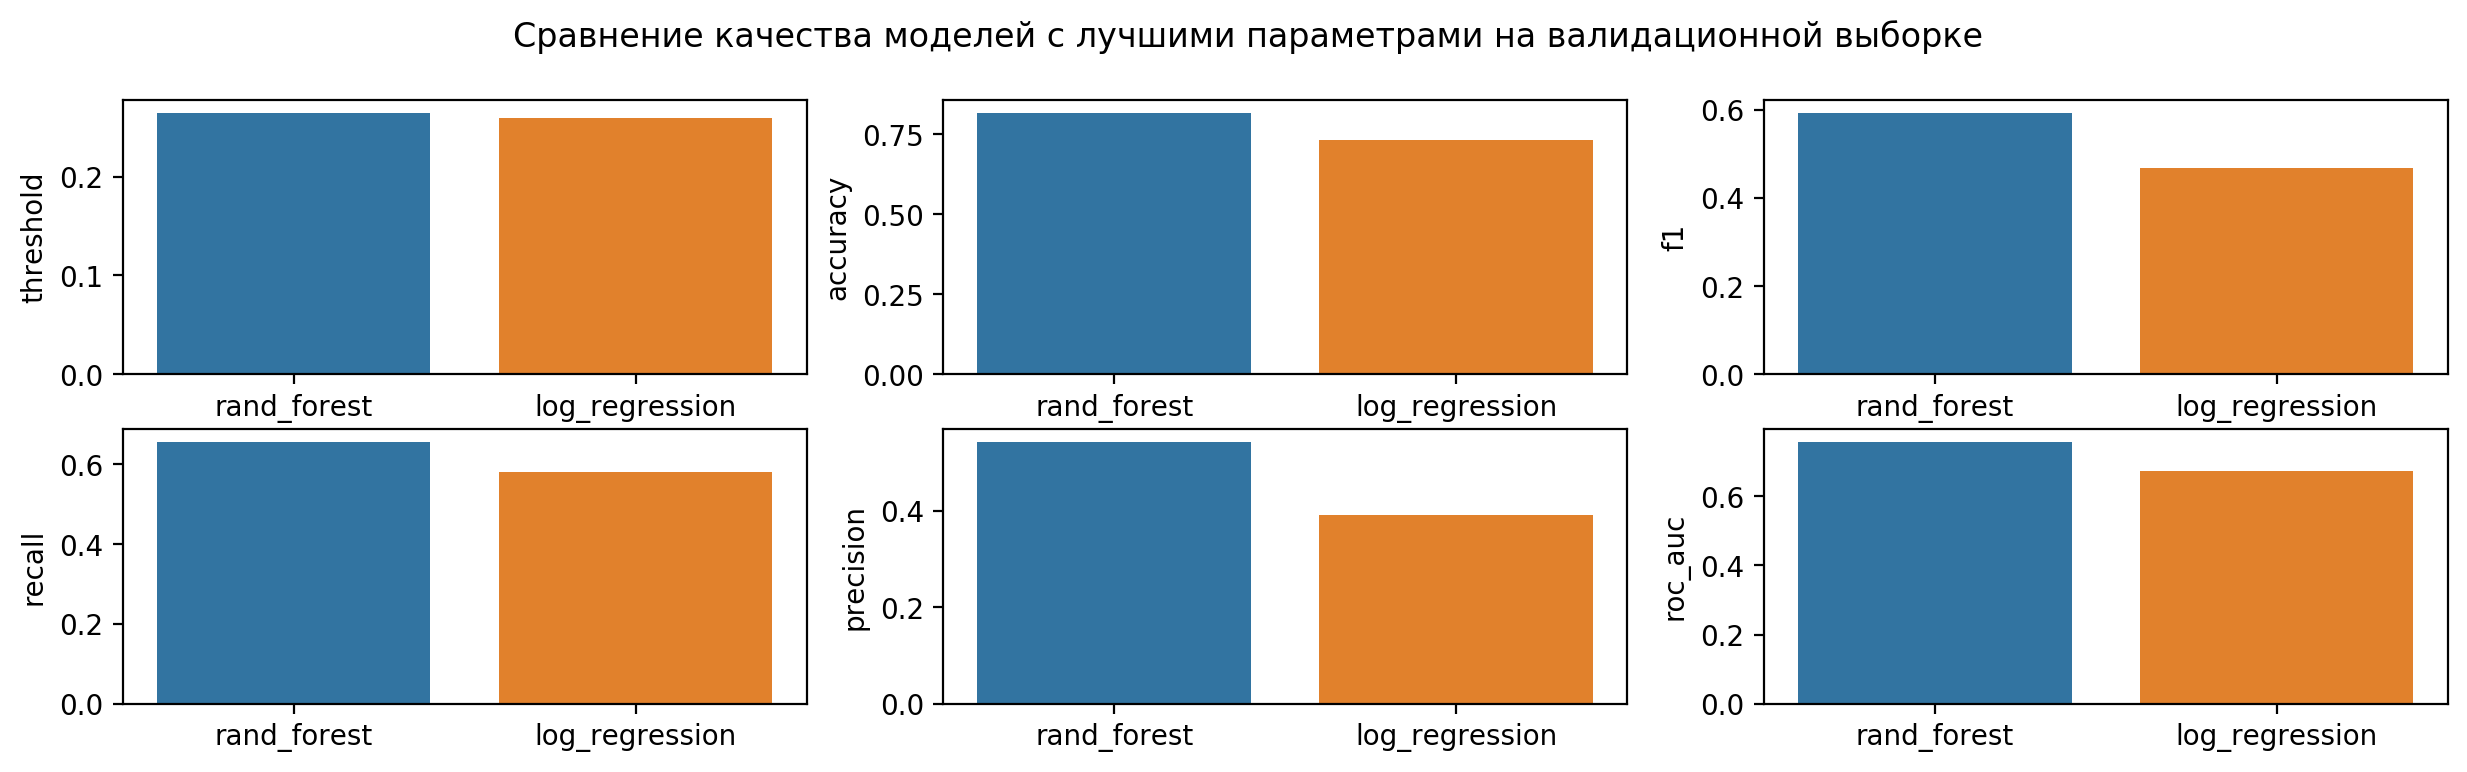

In [58]:
with Image(st='Сравнение качества моделей с лучшими параметрами на валидационной выборке', tight=False):
    for i, col in enumerate(comparison_unbal.columns):
        Image.subplot(231 + i)
        sns.barplot(comparison_unbal.index, comparison_unbal[col])

Как видно из диаграмм, логистическая регрессия уступает случайному лесу по всем критериям оценки. Но мы будем надеяться, что она покажет себя со сбалансированными класами.

### Вывод из обучения моделей без балансировки классов
- Мы оценили разницу в количестве объектов положительного и отрицательного классов: их пропорция составляет примерно 4:1.
- Испытали сломанную модель и получили с её помощью точность, близкую к *80%*, однако F1 и AUROC показали её несостоятельность.
- Обучили две модели при помощи Grid Search: случайный лес и логистическую регрессию:
    - Со случайным лесом нам удалось достичь целевого значения F1. После чего мы поиграли с пороговыми значениями предсказанных вероятностей и улучшили полноту ответов, не теряя при этом F1.
    - Логистическая регрессия не смогла показать достаточное для нас значение F1, но мы не стали отбрасывать её, потому что не знаем, какой результат она покажет, обучившись с балансом классов.
    
[к оглавлению](#toc)

---

## 4. Обучение моделей с учётом дисбаланса классов <a id="balanced"></a>
В этом разделе мы обучим случайный лес и логистическую регрессию, но теперь придадим классам одинаковый вес. Для этого будем использовать гиперпараметры моделей.

### Случайный лес

In [59]:
# Обучаем с той же сеткой параметров, что и до этого
forest_gs_bal = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=30, class_weight='balanced'),
                             param_grid=forest_gs.param_grid, scoring=scorers, refit='f1')

In [60]:
%%time

forest_gs_bal.fit(x_train, y_train)

CPU times: user 2min 38s, sys: 2.24 s, total: 2min 41s
Wall time: 2min 41s


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jo...one,
                                              oob_score=False, random_state=0,
                            

In [61]:
df(forest_gs_bal.cv_results_).iloc[forest_gs_bal.best_index_]

mean_fit_time                                                       0.106297
std_fit_time                                                      0.00393366
mean_score_time                                                    0.0156466
std_score_time                                                   0.000251208
param_criterion                                                         gini
param_max_depth                                                           11
param_min_samples_leaf                                                     4
param_min_samples_split                                                    2
params                     {'criterion': 'gini', 'max_depth': 11, 'min_sa...
split0_test_accuracy                                                0.845833
split1_test_accuracy                                                  0.8375
split2_test_accuracy                                                0.850833
split3_test_accuracy                                                0.861667

- На модели случайного леса мы получили прирост метрики F1 до среднего в *0.63*, что ощутимо лучше, чем *0.6*, полученные без учёта дисбаланса классов.
- AUROC остался близок к тому же значению, что было до этого.

Посмотрим, сможем ли мы улучшить показатель полноты ещё больше перебором порогов.

In [62]:
forest_f1_ok_bal = proba_thresholds(forest_gs_bal.best_estimator_, x_val, y_val).query('f1 >= 0.59')
forest_f1_ok_bal

,threshold,accuracy,f1,recall,precision,roc_auc
83,0.415,0.8060,0.594990,0.700246,0.517241,0.766633
84,0.420,0.8090,0.598739,0.700246,0.522936,0.768516
85,0.425,0.8100,0.597458,0.692875,0.525140,0.766400
86,0.430,0.8125,0.598930,0.687961,0.530303,0.766140
87,0.435,0.8140,0.598272,0.680590,0.533719,0.764338
88,0.440,0.8145,0.596300,0.673219,0.535156,0.761908
89,0.445,0.8155,0.594059,0.663391,0.537849,0.758877
90,0.450,0.8205,0.599777,0.660934,0.548980,0.761101
91,0.455,0.8215,0.595696,0.646192,0.552521,0.756241
92,0.460,0.8240,0.597254,0.641278,0.558887,0.755981


Если пользоваться порогами, то наше значение F1 сильно падает и не поднимается до *0.6* даже в лучших случаях. Поэтому для тестовой выборки мы оставим модель леса, которая получилась без использования порогов.

In [63]:
# Запишем модель в переменную
forest_bal = forest_gs_bal.best_estimator_

---

### Логистическая регрессия
Проделаем аналогичные действия над логистической регрессией и посмотрим, сможет ли она выдать нормальное значение F1 с учётом дисбаланса классов.

In [64]:
lr_gs_bal = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                         param_grid=lr_gs.param_grid,
                         scoring=scorers, refit='f1')

In [65]:
lr_gs_bal.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]),
                         'fit_intercept': [True, False],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,


Улучшилось ли качество регрессии?

In [66]:
df(lr_gs_bal.cv_results_).loc[lr_gs_bal.best_index_, :]

mean_fit_time                                                    0.0131637
std_fit_time                                                   0.000371623
mean_score_time                                                 0.00482244
std_score_time                                                 7.41572e-05
param_C                                                                0.1
param_fit_intercept                                                  False
param_solver                                                     newton-cg
params                   {'C': 0.1000000000000002, 'fit_intercept': Fal...
split0_test_accuracy                                              0.729167
split1_test_accuracy                                                  0.73
split2_test_accuracy                                                0.7475
split3_test_accuracy                                                0.7425
split4_test_accuracy                                              0.715833
mean_test_accuracy       

F1 заметно выросла, но этого по-прежнему не достаточно. Узнаем, какой максимальной F1 можно достичь с использованием порога.

In [67]:
proba_thresholds(lr_gs_bal, x_val, y_val, step=0.0005).f1.max()

0.4839024390243903

F1 даже ниже F1 по Grid Search. Использовать порог нет смысла.

### Вывод из обучения с балансировкой классов
- Мы обучили случайный лес и логистическую регрессию, но на этот раз учли дисбаланс классов, придав им разный вес.
- У обеих моделей вырозло значение F1, но использование порогов при предсказании вероятности ухудшило результаты, поэтому мы от них отказались.
- Логистическая регрессия не достигла целевой *F1 == 0.59*, поэтому на тестовой выборке мы будем испытывать случайный лес.

[к оглавлению](#toc)

---

## 5. Финальное тестирование <a id="test"></a>

Мы выбрали в качестве основной модели случайный лес. Модель уже обучена и показала неплохой результат на валидационной выборке.

In [68]:
from sklearn.metrics import classification_report

In [69]:
model = forest_bal

In [70]:
preds = forest_bal.predict(x_test)

In [71]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1593
           1       0.58      0.61      0.59       407

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000



На валидационной выборке F1 была сильно лучше, но нам этого достаточно. **Условие проекта выполнено**.

[к оглавлению](#toc)

---

## 6. Общий вывод <a id="conclusion"></a>

- Нашей задачей было построить модель, которая предсказывала бы вероятный уход клиентов из банка, чтобы суметь их вовремя выявить и удержать.
- Мы изучили датасет и подготовили его к обучению:
    - Избавились от лишних данных.
    - Закодировали категориальные признаки по принципу One-Hot.
    - Отмасштабировали количественные признаки, чтобы повысить точность логистической регрессии.
    - Выделили дополнительный признак - нулевой баланс.
- Обучили модели случайного леса и логистической регрессии:
    - Без учёта дисбалансов класса только случайный лес показал достаточный результат.
    - С учётом дисбаланса качество обеих моделей улучшилось, но логистическая регрессия так и не набрала достаточного значения F1.
- Проверили случайный лес с оптимальными параметрами на тестовой выборке и получили F1, достаточное по условию проекта.

[к оглавлению](#toc)

---